# Hospital/Food Vendor Project

#### Import LIbraries

In [310]:
import pandas as pd
import numpy as np
import folium

# import for requests and foursquare calls
import requests
import json
import re
import bs4
import foursquare

# import for kmeans-clustering
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#Import geopandas for folium maps
import geopandas as gpd



### Utility Functions 
#### Beautiful Soup Scrape Function

In [2]:
# utility function to turn a webpage into a scrape soup
def run_bs4(link):
    """Runs beautiful soup on a link. Returns the url in beautiful soup markup'.

    Parameters
    ----------
    link : string
        a string of the desired url.
   

    Returns
    -------
    BeautifulSoupHtml
        Returns the content of the url in Beautiful Soup markup.

    """
    user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.122 Safari/537.36'
    headers = {'User-Agent': user_agent}
    page = requests.get(link)
    html = page.content
    soup = bs4.BeautifulSoup(html, 'html.parser')
    return(soup)

# scrape function that gets rating and number of reviews from yelp
def get_rating_from_yelp(link):
    """Makes a call to the yelp url and returns ratings and review information '.

    Parameters
    ----------
    link : string
        a string of a yelp url.

    Returns
    -------
    tuple
        A tuple of ratings in the format '4 stars' and number of reviews in the format '1223 reviews' .

    """
    soup_ = run_bs4(link)
    rating = []
    num_ratings = []
    for x in soup_.find_all('div', class_="lemon--div__373c0__1mboc arrange-unit__373c0__1piwO arrange-unit-fill__373c0__17z0h border-color--default__373c0__2oFDT"):
        for y in x.find_all('div'):
            if y.get('aria-label'):
                rating=y.get('aria-label')
            
            if y.find_all('p'):
                for z in y.find_all('p'):
                    if 'reviews' in str(z):
                        num_ratings = z.find(text=True)
                        break
            
    return((rating, num_ratings))



# Part 1
--------
## Load Bay Area Hospital Locations and Create a folium Map of Hospital Locations
Note that the wikipedia page used to get a list did not include Marin County Hospitals. A separate scrape off yelp got a list of top Marin County Hospitals. Included in Bay Area Hospital Locations was a hospital from Long Beach outside Los Angeles (8 plus hours away), Modesto (a few hours away), and Fresno. Some hospitals share addresses (or were listed as separate hospitals, but are housed at the same location). 

Some side analysis: 51 hospitals may be too many hospital to analyze. However 7.15 million people live in the Bay area. The Bay Area is composed of nine counties: Alameda, Contra Costa, Marin, Napa, San Francisco, San Mateo, Santa Clara, Solano amd Sonoma.

In [52]:
# Load Hospital Locations
# For details on the scrape of this csv please see the "Hospital and Location Scrape Notebook"
df_hospitals = pd.read_csv('../data/Hospital_locations.csv')
marin_hops = pd.read_csv('../data/marin_hospit.csv')

In [53]:
# Check Number of Hospitals
df_hospitals.shape, marin_hops.shape

((54, 5), (9, 5))

In [71]:
# concat Marin and Bay hospital dataframes
df_hospitals = pd.concat([df_hospitals, marin_hops]).reset_index()

In [78]:
# Drop hospitals not in the Bay Area (Modest, Long Beach, Fresno, and Clearlake 
# hospitals somehow made the list on Wikipedia)
df_hospitals = df_hospitals[~df_hospitals['locale'].isin(['California', 'Long Beach', 'Modesto', 'Fresno', 'Clearlake'])]

In [79]:
# Dropping the hospitals in Fresno
df_hospitals = df_hospitals[~df_hospitals['address'].str.contains('California, USA')]

In [80]:
# Check and drop duplicates
df_hospitals = df_hospitals.drop_duplicates(subset=['address'], keep='last')
df_hospitals.shape

(51, 6)

In [81]:
# SF coordinates
sf_lat = 37.773972
sf_long = -122.431297

In [541]:
# create map of San Francisco using latitude and longitude values
map_sf = folium.Map(location=[sf_lat, sf_long], zoom_start=11)

# add markers to map
for lat, lng, hospital, address,  in zip(df_hospitals['lat'], df_hospitals['lng'], df_hospitals['name'], df_hospitals['address']):
    label = '{} \n {}'.format(hospital, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sf)  
    
map_sf

In [542]:
#Save Map 
map_sf.save("../data/hospitals_sf.html")

# Part 2
------
## USE FOURSQUARE TO GET FOOD VENUES AROUND HOSPITALS

In [84]:
# Credentials 
CLIENT_ID = '0I4KDZAGDIBSJSWLA0KIG35A3DCPGHYXETFHRHGURJ31HDFW' # your Foursquare ID
CLIENT_SECRET = 'ITRLXIQPIFEDIJZVSKYB3YGHFNFOXUWOIEU1CHSQGDXVMGIE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [85]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']



In [90]:
# function returns nearby food venues of a particular place
def getNearbyVenues(names, latitudes, longitudes, radius=1600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&section=food'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng)
        
        try:

            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            city = results[0]['venue']['location']['city']
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng,
                city,
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],
                v['venue']['categories'][0]['name']) for v in results])


            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['Hospital', 
                          'Hospital Latitude', 
                      'Hospital Longitude',  
                      'Venue City',
                      'Venue',
                      'Venue Latitude', 
                      'Venue Longitude',
                      'Venue Category']
       
        except:
            print("TRY AGAIN", name)
    
    return(nearby_venues)


hospital_venues = getNearbyVenues(names=df_hospitals['name'],
                                   latitudes=df_hospitals['lat'],
                                   longitudes=df_hospitals['lng'])



Agnews Developmental Center
Alameda Hospital
Alta Bates Summit Medical Center
Brookside Hospital
Doctors Medical Center San Pablo Campus
El Camino Hospital
Good Samaritan Hospital (San Jose)
John George Psychiatric Pavilion
John Muir Medical Center (Concord Campus)
John Muir Medical Center (Walnut Creek Campus)
Kaiser Richmond Field Hospital
Napa State Hospital
Naval Hospital Oakland
OConnor Hospital
Queen of the Valley Medical Center
Richmond Medical Center
Adventist Health St. Helena
Sequoia Hospital
Seton Medical Center
St. Rose Hospital
Sutter Delta Medical Center
Vacaville Medical Center
Veterans Home of California Yountville
Childrens Hospital Oakland
Highland Hospital (Oakland, California)
Oakland Medical Center
Davies Medical Center
Friends of Laguna Honda Hospital
Langley Porter Psychiatric Institute
Saint Francis Memorial Hospital
St. Josephs Hospital (San Francisco)
St. Lukes Hospital (San Francisco, California)
St. Marys Medical Center (San Francisco)
San Francisco Chinese 

In [91]:
# Rename Hospital Venues Columns
hospital_venues.columns = ['Hospital', 
                  'Hospital Latitude', 
                  'Hospital Longitude',  
                  'Venue City',
                  'Venue',
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']

In [92]:
# there are 1530 venues within these 51 hospitals
hospital_venues.shape

(1530, 8)

In [93]:
# Make yelp links for each food venue
hospital_venues['yelp_link'] = hospital_venues['Venue'].str.lower()
hospital_venues['yelp_link'] = hospital_venues['yelp_link'].str.replace("'", '')
hospital_venues['yelp_link'] = hospital_venues['yelp_link'].str.replace('&', 'and')
hospital_venues['yelp_link'] = 'https://www.yelp.com/biz/' + hospital_venues['yelp_link'] \
                             +'-'+hospital_venues['Venue City'].str.lower()
hospital_venues['yelp_link'] = hospital_venues['yelp_link'].str.replace(' ', '-')

In [33]:
# check function 'get_rating_from_yelp' is working
get_rating_from_yelp('https://www.yelp.com/biz/blue-dot-cafe-and-coffee-bar-alameda?osq=blue+dot')

('3.5 star rating', '345 reviews')

In [98]:
# initial empty lists for the dataframe; will be replaced with values from the yelp scrape
hospital_venues['ratings'] = np.empty(hospital_venues.shape[0])
hospital_venues['reviews'] = np.empty(hospital_venues.shape[0])


In [191]:
# rate of scrape ~ 2 minutes per hospital
# scrape for ratings
# ratings = []
for no, x in zip(hospital_venues.index[1437:], hospital_venues['yelp_link'][1437:]):
    x.replace("'", '')
    print(x)
    #print(hospital_venues.loc[no, 'Venue'])
    rr = get_rating_from_yelp(x)
    print(rr[0], rr[1], no)
    # ratings.append(get_rating_from_yelp(x))
    hospital_venues.loc[no, 'ratings'] = str(rr[0])
    hospital_venues.loc[no, 'reviews'] = str(rr[1])


https://www.yelp.com/biz/black-bear-diner-sonoma
3 star rating 203 reviews 1437
https://www.yelp.com/biz/vineburg-deli-and-grocery-sonoma
[] [] 1438
https://www.yelp.com/biz/oso-sonoma-sonoma
4 star rating 473 reviews 1439
https://www.yelp.com/biz/mi-pueblo-novato
[] [] 1440
https://www.yelp.com/biz/in-n-out-burger-novato
3.5 star rating 144 reviews 1441
https://www.yelp.com/biz/rustic-bakery-novato
[] [] 1442
https://www.yelp.com/biz/masas-novato
[] [] 1443
https://www.yelp.com/biz/the-habit-burger-grill-novato
[] [] 1444
https://www.yelp.com/biz/chao-praya-novato
4 star rating 222 reviews 1445
https://www.yelp.com/biz/chick-fil-a-novato
[] [] 1446
https://www.yelp.com/biz/creekside-bakery-novato
4.5 star rating 207 reviews 1447
https://www.yelp.com/biz/ghiringhelli-pizzeria-grill-and-bar-novato
3.5 star rating 263 reviews 1448
https://www.yelp.com/biz/marvins-restaurant-novato
4.5 star rating 666 reviews 1449
https://www.yelp.com/biz/redwood-bagel-novato
[] [] 1450
https://www.yelp.c

In [245]:
# finding the index of venues without yelp reviews and how many there are

yelp_redo_index = hospital_venues.index[hospital_venues['reviews']=='[]']
len(yelp_redo_index)

81

In [220]:
# find nan rating values
yelp_redo_index = hospital_venues.index[hospital_venues['reviews']=='[]']


# re-scrape accounting for some str anomalies 
ratings_again = []
for no, x in zip(yelp_redo_index, hospital_venues.loc[yelp_redo_index, :]['yelp_link']):
    name = hospital_venues.loc[no, 'Venue'].lower()
    x = x.replace("’", "")
    x = x.replace("(taco-truck-", "")
    # x = x.replace("-richmond", '')
    x = x.replace('hunan-cuisine', 'santa-clara')
    # x = x.replace('shop', 'garden')
    x = x.replace('caspers-richmond', 'caspers-richmond-richmond')
    x = x.replace('--', '-')
    x = x.replace("ñ", "n")
    x = x.replace(".", "")
    x = x.replace('cliff-house', 'cliff-house-terrace-room-champagne-brunch')
    
    x = x.replace('!', '')
    # x = x.replace("bbq-", "")
    x = x.replace("good-eats-", "")
    #x = x.replace('restaurant', '')
    x = x.replace('+', 'and')
    x = x.replace('™', '')
    x = x.replace('chisme', 'chisme-cantina')
    x = x.replace('acacia-house','acacia-house-by-chris-cosentino')
    x = x.replace('homestyle-diner-and-', '')
    x = x.replace('jonathans-', 'johnathans-')
    x = x.replace('oakland', 'san-leandro')
    x = x.replace('masas', 'masas-sushi')
    x = x.replace('cecils-burgers', 'cecils-famous-burgers')
    x = x.replace('cheese-steak', 'the-cheese-steak')
    x = x.replace('teni-', 'teni-east-kitchen-')
    # x = x.replace('san-pablo', 'san-francisco')
    # x = x.replace('san-carlos', 'redwood-city')
    x = x.replace('san-jose', 'los-gatos')
    # x = x.replace('daly-city', 'san-francisco')
    # x = x.replace('long-beach', 'san-francisco')
    x = x.replace('khanhs', 'khanhs-restaurant')
    x = x.replace('ở', 'o')
    x = x.replace('á', 'a')
    x = x.replace('-chicago', '')
    x = x.replace('---', '-')
    
    x = x.replace('-santa-clara', '')
    x = x.replace('ańh', 'anhs')
    x = x.replace('#', '')
    x = x.replace(',', '')
    x = x.replace('俏龍軒-', '')
    x = x.replace('il-posto', 'il-posto-trattoria')
    x = x.replace('espana', '')
    x = x.replace(' 鯉魚門海鮮茶寮 (koi palace)', '')
    x = x.replace("cholita-linda-alameda", 'cholita-linda-alameda-8')
    # x = x.replace('deli', 'gourmet-delicatessen')
    # x = x.replace('tartine', 'tartine-bakery-and-cafe')
    x = x.replace('-san-francisco', '')
    x = x.replace('risibisi', 'risibisi-restaurant')
    x = x.replace('starbread-richmond', 'starbread-san-pablo-2')
    x = x.replace('the-restaurant-at-auberge-du-soleil-saint-helena', 'auberge-du-soleil-restaurant-rutherford')
    x = x.replace('spinster-sisters', 'the-spinster-sisters')
    x = x.replace('-saint-helena', '')
    x = x.replace('wwwyelpcom', 'www.yelp.com')
    x = x.replace(':-', '')
    x = x.replace('greenbrae', 'kentfield')
    x = x.replace('brazucca', 'brazzuca')
    # x = x.replace('antioch', 'hercules')
    x = x.replace('--', '-')
    print(name)
    
    # x = x.replace('-alameda', '-alameda?osq='+name)
    rr = get_rating_from_yelp(x)
    print(x, no, rr)
    hospital_venues.loc[no, 'ratings'] = str(rr[0])
    hospital_venues.loc[no, 'reviews'] = str(rr[1])


melts my heart truck
https://www.yelp.com/biz/melts-my-heart-truck 11 ([], [])
sendo sushi
https://www.yelp.com/biz/sendo-sushi 14 ([], [])
curry up now
https://www.yelp.com/biz/curry-up-now 18 ([], [])
la catalana españa restaurant
https://www.yelp.com/biz/la-catalana-restaurant 20 ([], [])
patxi's chicago pizza
https://www.yelp.com/biz/patxis-pizza 25 ([], [])
pokéworks
https://www.yelp.com/biz/pokéworks 26 ([], [])
asena
https://www.yelp.com/biz/asena-alameda 59 ([], [])
mua oakland bar & restaurant
https://www.yelp.com/biz/mua-san-leandro-bar-and-restaurant-san-leandro 77 ([], [])
wooden table cafe
https://www.yelp.com/biz/wooden-table-cafe-san-leandro 86 ([], [])
kaliente
https://www.yelp.com/biz/kaliente-san-francisco 112 ([], [])
los moles hecho en casa
https://www.yelp.com/biz/los-moles-hecho-en-casa-san-francisco 113 ([], [])
los moles hecho en casa
https://www.yelp.com/biz/los-moles-hecho-en-casa-san-francisco 142 ([], [])
kaliente
https://www.yelp.com/biz/kaliente-san-franci

In [222]:
# Check for duplicate venues and seeing if one of them has scrape information

# create a dictionary key for each repeat venue and store the index of venue
multiple_rest = []
restaurant_dict = {}
# FIND DUPLICATE VENUES:
for x in hospital_venues['Venue'].unique():
    idx = hospital_venues.index[hospital_venues['Venue'] == x]
    restaurant_dict[x] = idx.to_list()
    if len(restaurant_dict[x]) >1:
        multiple_rest.append(idx[0])
        
len(restaurant_dict), len(multiple_rest)

(1094, 222)

In [223]:
#check if ratings exist
for key, values in restaurant_dict.items():
    if len(values) > 1: 
        print(key, hospital_venues.loc[values, 'ratings'])

Chipotle Mexican Grill 2       2.5 star rating
13      2.5 star rating
29      2.5 star rating
47      4.5 star rating
67      3.5 star rating
192       4 star rating
259       3 star rating
402     2.5 star rating
774       4 star rating
1339      3 star rating
Name: ratings, dtype: object
Jersey Mike's Subs 6      3.5 star rating
103    3.5 star rating
133    3.5 star rating
164      4 star rating
183    3.5 star rating
475    3.5 star rating
643    3.5 star rating
Name: ratings, dtype: object
In-N-Out Burger 9         4 star rating
117       4 star rating
153       4 star rating
215       4 star rating
330     4.5 star rating
376       4 star rating
523     3.5 star rating
540     3.5 star rating
545     3.5 star rating
606       4 star rating
612       4 star rating
632       4 star rating
1291      4 star rating
1334      4 star rating
1441    3.5 star rating
Name: ratings, dtype: object
Chick-fil-A 16      3.5 star rating
292     3.5 star rating
635       4 star rating
1296      

MOD Pizza 335     4.5 star rating
620     4.5 star rating
1308    4.5 star rating
1458    3.5 star rating
Name: ratings, dtype: object
Hog Island Oyster Co. 336    4 star rating
434    4 star rating
Name: ratings, dtype: object
Model Bakery 338    3.5 star rating
439      4 star rating
Name: ratings, dtype: object
Bounty Hunter Wine Bar & Smokin' BBQ 339    4 star rating
443    4 star rating
Name: ratings, dtype: object
Five Dot Ranch 341    4 star rating
442    4 star rating
Name: ratings, dtype: object
Don Perico Restaurant 348    2.5 star rating
448    2.5 star rating
Name: ratings, dtype: object
Kenzo 350    4.5 star rating
444    4.5 star rating
Name: ratings, dtype: object
Gran Electrica 352    3.5 star rating
441      4 star rating
Name: ratings, dtype: object
C Casa 353    4 star rating
445    4 star rating
Name: ratings, dtype: object
85C Bakery Cafe 382    4 star rating
548    4 star rating
Name: ratings, dtype: object
Koja Kitchen 404     4 star rating
1522    4 star rating


Name: ratings, dtype: object
Los Moles 1362    4 star rating
1406    4 star rating
Name: ratings, dtype: object
Ponsford's Place Bakery 1365    4 star rating
1394    4 star rating
Name: ratings, dtype: object
Il Davide Cucina Italiana 1366    4 star rating
1405    4 star rating
Name: ratings, dtype: object
Johnny Doughnuts 1367    3.5 star rating
1395      4 star rating
Name: ratings, dtype: object
Le Comptoir 1372    4 star rating
1407    4 star rating
Name: ratings, dtype: object
Casa Mañana 1374      4 star rating
1399    4.5 star rating
Name: ratings, dtype: object
Miracle Mile Cafe 1376    3.5 star rating
1391    3.5 star rating
Name: ratings, dtype: object


In [230]:
# Find Duplicate adn Empty Ratings, Fill with nonempty Ratings

for x in multiple_rest:
    # print(hospital_venues.loc[x, 'rating'])
    venue = hospital_venues.loc[x, 'Venue']
    mean_ = hospital_venues[hospital_venues['Venue']==venue]['ratings']

    idx = hospital_venues.index[hospital_venues['Venue']==venue]
    for y in idx:
        if hospital_venues.loc[y, 'ratings'] == '[]':
            hospital_venues.loc[y, 'ratings'] = hospital_venues.loc[x, 'ratings']
        if hospital_venues.loc[y, 'reviews'] == '[]':
                hospital_venues.loc[y, 'reviews'] = hospital_venues.loc[x, 'reviews']
        if hospital_venues.loc[y, 'ratings'] != '[]' and hospital_venues.loc[x, 'ratings']=='[]':
            hospital_venues.loc[x, 'ratings'] = hospital_venues.loc[y, 'ratings']
        if hospital_venues.loc[y, 'reviews'] != '[]'and hospital_venues.loc[x, 'reviews']=='[]':
                hospital_venues.loc[x, 'reviews'] = hospital_venues.loc[y, 'reviews']
                

    print(venue)

Chipotle Mexican Grill
Jersey Mike's Subs
In-N-Out Burger
Chick-fil-A
Panda Express
Burma Superstar
The Star
Cholita Linda
Five Guys
Judoku Sushi
Cat Town Cafe
Beauty's Bagel Shop
Doña
The Wolf
Dan Sung Sa
CHICA Oakland
Seoul Gom Tang
Homeroom
Homeroom To Go
Clove & Hoof Restaurant
Commis
Tacos Oscar
Teni
Cato's Ale House
TrueBurger
Monster Pho
Geta Sushi
Homestead
Starbread
El Pollo Loco
Americana's Pizza/Taqueria
Blue Bay Thai Cuisine
Taqueria La Bamba - Richmond
Portumex Restaurant
La Strada Italian Restaurant
Sukie's Country Kitchen
Rockin' Crawfish
Nation's Giant Hamburgers
Tacos Los Primos (Burrito Truck)
Door De Jalisco Taco Truck
CJ's Barbecue & Fish
Huong Tra
Taqueria Maria
Andy's Donut Stop
Mi Virgencita Taqueria Taco Truck
Phở Thái Hùng
Banana Leaf Thai Cuisine
Angelo's Deli
GangNam Tofu
Kaliente
Los Moles Hecho En Casa
Tacos Rodriguez
Caspers
3 hermanas
Empire Buffet
Round Table Pizza
House of Bagels
The Sandwich Spot
A Slice of New York
Blue Line Pizza
Panera Bread
Subway


In [226]:
# checking value counts of ratings
hospital_venues['ratings'].value_counts()>3


4 star rating      True
3.5 star rating    True
4.5 star rating    True
[]                 True
3 star rating      True
2.5 star rating    True
2 star rating      True
5 star rating      True
Name: ratings, dtype: bool

In [232]:
# making ratings and reviews numerical 
hospital_venues['ratings'] = hospital_venues['ratings'].str.replace(' star rating', "")
hospital_venues['reviews'] = hospital_venues['reviews'].str.replace('reviews', "")


In [548]:
# mean and median of ratings
hospital_venues['ratings'].mean(), hospital_venues['ratings'].median()

(3.906832298136646, 4.0)

In [550]:
# mean and median number of reviews
hospital_venues['reviews'].astype(float).mean(), hospital_venues['reviews'].astype(float).median()

(674.3133195307108, 427.0)

In [235]:
# check to see how many venues do not have rating data
# no rating data someone correlates to closed venues
no_ratings = hospital_venues[hospital_venues['reviews']== '[]']

In [250]:
no_ratings.columns

Index(['Hospital', 'Hospital Latitude', 'Hospital Longitude', 'Venue City',
       'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category',
       'yelp_link', 'ratings', 'reviews'],
      dtype='object')

In [251]:
# mean number of venues that did not have a rating per hospital clsuter
no_ratings.groupby(['Hospital'])['ratings'].count().mean()

2.3142857142857145

In [252]:
# percent of venues that are possibly closed/don't have ratings
round(len(yelp_redo_index)/hospital_venues.shape[0]*100, 2)

5.29

In [249]:
# save food venues data frame as csv
hospital_venues.to_csv('../data/hospital_venues_ratings_april_23.csv')

In [113]:
# load from saved file
hospital_venues = pd.read_csv('../data/hospital_venues_ratings_april_23.csv')

# PART 3 Kmeans Clustering, Plotting, and Visualizing



## ONE HOT ENCODING FOR VENUE TYPE

In [253]:
# one hot encoding
sf_onehot = pd.get_dummies(hospital_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sf_onehot['Hospital'] = hospital_venues['Hospital'] 

# move neighborhood column to the first column
fixed_columns = [sf_onehot.columns[-1]] + list(sf_onehot.columns[:-1])
sf_onehot = sf_onehot[fixed_columns]

# group venues by mean number of venues
hospital_grouped = sf_onehot.groupby('Hospital').mean().reset_index()

In [254]:
# inspect initial cluster patterns
num_top_venues = 5

for hood in hospital_grouped['Hospital']:
    print("----"+hood+"----")
    temp = hospital_grouped[hospital_grouped['Hospital'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adventist Health St. Helena----
                     venue  freq
0      American Restaurant  0.27
1  New American Restaurant  0.13
2               Restaurant  0.10
3      Japanese Restaurant  0.07
4       Mexican Restaurant  0.07


----Agnews Developmental Center----
                   venue  freq
0     Mexican Restaurant  0.17
1            Pizza Place  0.07
2  Vietnamese Restaurant  0.07
3   Fast Food Restaurant  0.07
4     Chinese Restaurant  0.07


----Alameda Hospital----
                       venue  freq
0         Mexican Restaurant  0.10
1           Sushi Restaurant  0.07
2                       Café  0.07
3  Middle Eastern Restaurant  0.07
4                     Bakery  0.07


----Alta Bates Summit Medical Center----
                 venue  freq
0  American Restaurant  0.13
1   Mexican Restaurant  0.10
2    Korean Restaurant  0.07
3           Food Truck  0.07
4   Mac & Cheese Joint  0.07


----Brookside Hospital----
                   venue  freq
0             Food Truck  0.

            venue  freq
0            Café  0.13
1  Sandwich Place  0.10
2     Pizza Place  0.07
3          Bakery  0.07
4  Breakfast Spot  0.07


----UCSF Helen Diller Family Comprehensive Cancer Center----
            venue  freq
0            Café  0.13
1     Pizza Place  0.07
2      Food Truck  0.07
3          Bakery  0.07
4  Sandwich Place  0.07


----UCSF Medical Center----
              venue  freq
0    Breakfast Spot  0.13
1  Sushi Restaurant  0.10
2    Sandwich Place  0.10
3   Thai Restaurant  0.07
4            Bakery  0.07


----University of California, San Francisco Fetal Treatment Center----
            venue  freq
0            Café  0.13
1     Pizza Place  0.10
2  Sandwich Place  0.10
3          Bakery  0.07
4  Breakfast Spot  0.07


----Vacaville Medical Center----
                  venue  freq
0    Mexican Restaurant  0.13
1           Pizza Place  0.10
2  Fast Food Restaurant  0.10
3    Italian Restaurant  0.07
4      Asian Restaurant  0.07


----Veterans Home of Californ

In [255]:
# Function returns the most comnon number of venues, user picks number
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [256]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Hospital']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hospitals_venues_sorted = pd.DataFrame(columns=columns)
hospitals_venues_sorted['Hospital'] = hospital_grouped['Hospital']

for ind in np.arange(hospital_grouped.shape[0]):
    hospitals_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hospital_grouped.iloc[ind, :], num_top_venues)

hospitals_venues_sorted.head()

Hospital 1st Most Common Venue  \
0       Adventist Health St. Helena   American Restaurant   
1       Agnews Developmental Center    Mexican Restaurant   
2                  Alameda Hospital    Mexican Restaurant   
3  Alta Bates Summit Medical Center   American Restaurant   
4                Brookside Hospital    Mexican Restaurant   

       2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
0    New American Restaurant            Restaurant    Japanese Restaurant   
1          Indian Restaurant            Restaurant  Vietnamese Restaurant   
2  Middle Eastern Restaurant           Pizza Place       Sushi Restaurant   
3         Mexican Restaurant    Mac & Cheese Joint      Korean Restaurant   
4                 Food Truck           Pizza Place    American Restaurant   

  5th Most Common Venue      6th Most Common Venue  7th Most Common Venue  \
0    Mexican Restaurant             Breakfast Spot     Italian Restaurant   
1            Food Truck       Fast Food Restaurant     Chinese Restaurant   
2                  Café                     Bakery           Burger Joint   
3                Bakery                 Food Truck                   Café   
4  Fast Food Restaurant  Latin American Restaurant  Vietnamese Restaurant   

  8th Most Common Venue    9th Most Common Venue     10th Most Common Venue  
0        Sandwich Place                     Café               Burger Joint  
1           Pizza Place               Steakhouse             Sandwich Place  
2                 Diner  New American Restaurant               Noodle House  
3             Gastropub             Burger Joint  Middle Eastern Restaurant  
4    Italian Restaurant            Deli / Bodega         Chinese Restaurant

## ONE HOT ENCODING FOR RATINGS

In [257]:
# one hot encoding
sf_onehot = pd.get_dummies(hospital_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sf_onehot['Hospital'] = hospital_venues['Hospital'] 

# move neighborhood column to the first column
fixed_columns = [sf_onehot.columns[-1]] + list(sf_onehot.columns[:-1])
sf_onehot = sf_onehot[fixed_columns]

sf_onehot.head()

hospital_grouped = sf_onehot.groupby('Hospital').mean().reset_index()
hospital_grouped.head()

Hospital  Afghan Restaurant  African Restaurant  \
0       Adventist Health St. Helena           0.000000                 0.0   
1       Agnews Developmental Center           0.000000                 0.0   
2                  Alameda Hospital           0.033333                 0.0   
3  Alta Bates Summit Medical Center           0.000000                 0.0   
4                Brookside Hospital           0.000000                 0.0   

   American Restaurant  Argentinian Restaurant  Asian Restaurant  BBQ Joint  \
0             0.266667                     0.0          0.000000   0.000000   
1             0.000000                     0.0          0.000000   0.033333   
2             0.033333                     0.0          0.000000   0.000000   
3             0.133333                     0.0          0.033333   0.000000   
4             0.066667                     0.0          0.033333   0.033333   

   Bagel Shop    Bakery    Bistro  ...  Spanish Restaurant  Steakhouse  \
0    0.000000  0.033333  0.033333  ...            0.000000    0.033333   
1    0.000000  0.033333  0.000000  ...            0.033333    0.033333   
2    0.000000  0.066667  0.000000  ...            0.000000    0.000000   
3    0.033333  0.066667  0.000000  ...            0.000000    0.000000   
4    0.000000  0.033333  0.000000  ...            0.000000    0.000000   

   Sushi Restaurant  Szechuan Restaurant  Taco Place  Tapas Restaurant  \
0          0.000000                  0.0         0.0               0.0   
1          0.033333                  0.0         0.0               0.0   
2          0.066667                  0.0         0.0               0.0   
3          0.033333                  0.0         0.0               0.0   
4          0.000000                  0.0         0.0               0.0   

   Thai Restaurant  Vegetarian / Vegan Restaurant  Vietnamese Restaurant  \
0         0.000000                            0.0               0.000000   
1         0.000000                            0.0               0.066667   
2         0.033333                            0.0               0.033333   
3         0.000000                            0.0               0.033333   
4         0.033333                            0.0               0.066667   

   Wings Joint  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  

[5 rows x 87 columns]

# KMEANS CLUSTERING (VENUES)

In [289]:
# set number of clusters
kclusters = 5

scores_ = []
for x in range(2, 30):
    kclusters = x
    hospital_grouped_clustering = hospital_grouped.drop('Hospital', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hospital_grouped_clustering)

    # append score to find a good kmeans label
    scores_.append((kclusters, kmeans.inertia_))

Text(0.5, 1.0, 'K-Cluster Scores Elbow Plot')

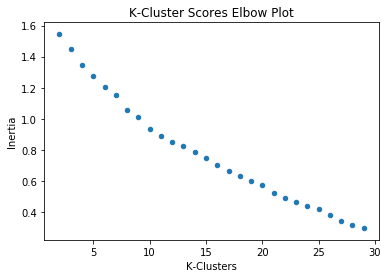

In [311]:
# Elbow Graph of different clustering scores... slight elbow at 10 and 20. 
scores = pd.DataFrame(scores_)
scores.columns=['K-Clusters', 'Inertia']
scores.plot(kind='scatter', x = 'K-Clusters', y='Inertia')
plt.title("K-Cluster Scores Elbow Plot")

In [345]:
# Using 10 Clusters 
kclusters = 7
hospital_grouped_clustering = hospital_grouped.drop('Hospital', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hospital_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:10] )

[6 0 4 5 0 5 2 0 2 1]


In [346]:
hospitals_venues_sorted.drop(columns=['Cluster Labels'], inplace=True)

In [347]:
# add clustering labels
hospitals_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sf_merged = df_hospitals

# merge sf_grouped with sf_data to add latitude/longitude for each neighborhood
sf_merged = sf_merged.join(hospitals_venues_sorted.set_index('Hospital'), on='name')

sf_merged.head() # check the last columns!

index                                     name        lat         lng  \
0      0              Agnews Developmental Center  37.394663 -121.959125   
1      1                         Alameda Hospital  37.762677 -122.254155   
2      3         Alta Bates Summit Medical Center  37.821648 -122.262967   
3      4                       Brookside Hospital  37.953721 -122.337278   
4      5  Doctors Medical Center San Pablo Campus  37.953091 -122.336511   

                                             address       locale  \
0                  Agnew, Santa Clara, CA 95054, USA  Santa Clara   
1           2070 Clinton Ave, Alameda, CA 94501, USA      Alameda   
2          350 Hawthorne Ave, Oakland, CA 94609, USA      Oakland   
3  Brookside Hospital Heliport, San Pablo, CA 948...    San Pablo   
4             2000 Vale Rd, San Pablo, CA 94806, USA    San Pablo   

   Cluster Labels 1st Most Common Venue      2nd Most Common Venue  \
0               0    Mexican Restaurant          Indian Restaurant   
1               4    Mexican Restaurant  Middle Eastern Restaurant   
2               5   American Restaurant         Mexican Restaurant   
3               0    Mexican Restaurant                 Food Truck   
4               0            Food Truck         Mexican Restaurant   

  3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
0            Restaurant  Vietnamese Restaurant            Food Truck   
1           Pizza Place       Sushi Restaurant                  Café   
2    Mac & Cheese Joint      Korean Restaurant                Bakery   
3           Pizza Place    American Restaurant  Fast Food Restaurant   
4           Pizza Place  Vietnamese Restaurant   American Restaurant   

       6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
0       Fast Food Restaurant     Chinese Restaurant           Pizza Place   
1                     Bakery           Burger Joint                 Diner   
2                 Food Truck                   Café             Gastropub   
3  Latin American Restaurant  Vietnamese Restaurant    Italian Restaurant   
4  Latin American Restaurant         Sandwich Place         Hot Dog Joint   

     9th Most Common Venue     10th Most Common Venue  
0               Steakhouse             Sandwich Place  
1  New American Restaurant               Noodle House  
2             Burger Joint  Middle Eastern Restaurant  
3            Deli / Bodega         Chinese Restaurant  
4       Italian Restaurant          Korean Restaurant

In [348]:
# Save to csv
sf_merged.to_csv("../data/cluster_april_29.csv", index=False)

In [349]:
sf_merged = sf_merged[sf_merged['Cluster Labels'].notnull()]

In [350]:
sf_merged['Cluster Labels'] = sf_merged['Cluster Labels'].astype(int)

In [351]:
sf_merged['Cluster Labels'].value_counts()

0    13
4    11
3     9
2     8
5     6
1     3
6     1
Name: Cluster Labels, dtype: int64

# Part 3 B Folium Maps

In [392]:
# read geolocation file for bay area shape files
df_geo = gpd.read_file('../../food_desert_pro/data/raw/bay_areafile.json')

In [371]:
# prep dataframe for merges with other dfs 
df_geo['FIPS'] = df_geo['FIPSSTCO'].astype(str).str.replace('60', '')
df_geo['FIPS'] = df_geo['FIPS'].astype(int)

In [393]:
df_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   OBJECTID  9 non-null      int64   
 1   FIPSSTCO  9 non-null      object  
 2   COUNTY    9 non-null      object  
 3   geometry  9 non-null      geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 416.0+ bytes


In [372]:
bay_area_covid = pd.read_csv('../data/bay_areaApr28.csv')

In [373]:
bay_area_covid

Unnamed: 0         county  % of Cases  deaths
0       95590        Alameda      19.758      59
1       95596   Contra Costa      10.718      25
2       95609          Marin       2.886      12
3       95615           Napa       0.852       2
4       95625  San Francisco      18.703      23
5       95628      San Mateo      13.973      48
6       95630    Santa Clara      26.980     107
7       95634         Solano       3.229       4
8       95635         Sonoma       2.899       2

In [398]:
df_geo = df_geo.merge(bay_area_covid[['county', '% of Cases', 'deaths']], how='left', left_on='COUNTY', right_on='county')

In [502]:

# {'purple', 'black', 'darkgreen', 'lightgreen', 'red', 'lightblue', 
# 'pink', 'orange', 'green', 'beige', 'lightred', 'darkpurple', 'white', 
# 'darkblue', 'darkred', 'cadetblue', 'blue', 'gray', 'lightgray'}.
color_dict = {0:'darkblue', 1: 'green', 2: 'orange', 3:'lightgreen', 4:'purple', 5:'darkred', 6:'darkgreen'}

In [146]:
sf_merged = pd.read_csv("../data/cluster_april_21.csv")

In [376]:
sf_merged['Cluster Labels'].value_counts()

0    13
4    11
3     9
2     8
5     6
1     3
6     1
Name: Cluster Labels, dtype: int64

In [395]:
sf_merged

index                                               name        lat  \
0       0                        Agnews Developmental Center  37.394663   
1       1                                   Alameda Hospital  37.762677   
2       3                   Alta Bates Summit Medical Center  37.821648   
3       4                                 Brookside Hospital  37.953721   
4       5            Doctors Medical Center San Pablo Campus  37.953091   
5       6                                 El Camino Hospital  37.368848   
6       7                 Good Samaritan Hospital (San Jose)  37.252044   
7       8                   John George Psychiatric Pavilion  37.710840   
8       9          John Muir Medical Center (Concord Campus)  37.982900   
9      10     John Muir Medical Center (Walnut Creek Campus)  37.912964   
10     11                     Kaiser Richmond Field Hospital  37.937188   
11     13                                Napa State Hospital  38.278364   
12     14                             Naval Hospital Oakland  37.765105   
13     15                                   OConnor Hospital  37.327557   
14     16                 Queen of the Valley Medical Center  38.324948   
16     18                            Richmond Medical Center  37.954990   
17     19                        Adventist Health St. Helena  38.542561   
19     23                                   Sequoia Hospital  37.480085   
20     24                               Seton Medical Center  37.679670   
21     26                                  St. Rose Hospital  37.633308   
22     27                        Sutter Delta Medical Center  37.982535   
23     28                           Vacaville Medical Center  38.388247   
24     29             Veterans Home of California Yountville  38.393452   
25     30                         Childrens Hospital Oakland  37.837190   
26     31            Highland Hospital (Oakland, California)  37.798902   
27     32                             Oakland Medical Center  37.823701   
28     34                              Davies Medical Center  37.768348   
29     35                   Friends of Laguna Honda Hospital  37.749223   
30     36               Langley Porter Psychiatric Institute  37.763560   
33     40                    Saint Francis Memorial Hospital  37.789380   
34     41               St. Josephs Hospital (San Francisco)  37.785467   
35     42     St. Lukes Hospital (San Francisco, California)  37.747535   
36     43           St. Marys Medical Center (San Francisco)  37.774058   
37     44                     San Francisco Chinese Hospital  37.795529   
38     45                          San Francisco City Clinic  37.779275   
39     46                     San Francisco General Hospital  37.756180   
40     47                    San Francisco VA Medical Center  37.782395   
41     49                    UCSF Benioff Childrens Hospital  37.764855   
42     50    UCSF Betty Irene Moore Women%E2%80%99s Hospital  37.765451   
43     51  UCSF Helen Diller Family Comprehensive Cancer ...  37.766267   
44     52                                UCSF Medical Center  37.763118   
45     53  University of California, San Francisco Fetal ...  37.765567   
55      0                         sonoma specialty hospital   38.397241   
56      1                         novato community hospital   38.099153   
57      2                          petaluma valley hospital   38.254591   
58      3                           san rafael convalescent   38.002665   
59      4                      kentfield hospital kentfield   37.958745   
60      5                            sonoma valley hospital   38.287975   
61      6                              sutter health novato   38.099152   
62      7                               santa rosa memorial   38.443620   
63      8                             kaiser permanente san   37.768267   

           lng                                            address  \
0  -121.959125                  Ag

In [503]:


m = folium.Map(location=[sf_lat, sf_long], tiles="openstreetmap", max_bounds = True, zoom_start=8)

folium.Choropleth(
    geo_data=df_geo,
    data=bay_area_covid,
    columns=['county', '% of Cases'],
    key_on= 'properties.COUNTY',
    fill_color='PuRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='Percent of COVID-19 Cases in Bay Area(%)',
    highlight=True
).add_to(m)

tooltip=folium.GeoJsonTooltip(
    fields=['COUNTY','% of Cases','deaths'],
    aliases=["County:", "% of Total Bay area Covid cases", "No. of Deaths"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        
        
    """
)

g = folium.GeoJson(
    df_geo,
    tooltip=tooltip,
).add_to(m)

folium.LayerControl().add_to(m)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sf_merged['lat'], sf_merged['lng'], sf_merged['name'], sf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color_dict[cluster],
        fill=True,
        fill_color=color_dict[cluster],
        fill_opacity=0.7).add_to(m)

m

In [403]:
m.save("clustered_hospitals_covid.html")

In [29]:
# Identify patterns of clusters based on food venues
# color_dict = {0:'blue', 1: 'green', 2: 'purple', 3:'orange', 4:'red', 5:'pink', 6:'grey'}
# color_dict = {0:'darkblue', 1: 'green', 2: 'orange', 3:'lightgreen', 4:'purple', 5:'darkred', 6:'darkgreen'}

In [356]:
# Dark Blue Clusters
sf_merged.loc[sf_merged['Cluster Labels'] == 0, sf_merged.columns[[0] + \
                                                     list(range(5, sf_merged.shape[1]))]]

index       locale  Cluster Labels 1st Most Common Venue  \
0       0  Santa Clara               0    Mexican Restaurant   
3       4    San Pablo               0    Mexican Restaurant   
4       5    San Pablo               0            Food Truck   
6       7     San Jose               0        Sandwich Place   
8       9      Concord               0    Mexican Restaurant   
11     13         Napa               0    Mexican Restaurant   
14     16         Napa               0    Mexican Restaurant   
21     26      Hayward               0    Mexican Restaurant   
22     27      Antioch               0  Fast Food Restaurant   
56      1       Novato               0          Burger Joint   
58      3   San Rafael               0    Mexican Restaurant   
60      5       Sonoma               0    Mexican Restaurant   
61      6       Novato               0          Burger Joint   

       2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
0          Indian Restaurant            Restaurant  Vietnamese Restaurant   
3                 Food Truck           Pizza Place    American Restaurant   
4         Mexican Restaurant           Pizza Place  Vietnamese Restaurant   
6         Mexican Restaurant          Burger Joint          Hot Dog Joint   
8   Mediterranean Restaurant    Chinese Restaurant      Indian Restaurant   
11       American Restaurant           Pizza Place       Sushi Restaurant   
14       American Restaurant    Italian Restaurant           Burger Joint   
21              Burger Joint   American Restaurant   Fast Food Restaurant   
22        Mexican Restaurant    Chinese Restaurant         Sandwich Place   
56           Thai Restaurant   American Restaurant     Mexican Restaurant   
58        Italian Restaurant        Breakfast Spot                  Diner   
60       American Restaurant           Pizza Place  Portuguese Restaurant   
61           Thai Restaurant   American Restaurant     Mexican Restaurant   

   5th Most Common Venue      6th Most Common Venue  \
0             Food Truck       Fast Food Restaurant   
3   Fast Food Restaurant  Latin American Restaurant   
4    American Restaurant  Latin American Restaurant   
6     Chinese Restaurant                 Donut Shop   
8           Burger Joint        Fried Chicken Joint   
11          Burger Joint                     Bakery   
14  Fast Food Restaurant                 Steakhouse   
21             BBQ Joint           Sushi Restaurant   
22           Pizza Place        American Restaurant   
56        Breakfast Spot           Sushi Restaurant   
58           Pizza Place        American Restaurant   
60     French Restaurant              Deli / Bodega   
61        Breakfast Spot           Sushi Restaurant   

        7th Most Common Venue 8th Most Common Venue  9th Most Common Venue  \
0          Chinese Restaurant           Pizza Place             Steakhouse   
3       Vietnamese Restaurant    Italian Restaurant          Deli / Bodega   
4              Sandwich Place         Hot Dog Joint     Italian Restaurant   
6   Latin American Restaurant    Italian Restaurant  Vietnamese Restaurant   
8       Vietnamese Restaurant    Italian Restaurant                  Diner   
11             Breakfast Spot    Italian Restaurant   Fast Food Restaurant   
14                  BBQ Joint                Bakery    Japanese Restaurant   
21         Chinese Restaurant     Indian Restaurant                  Diner   
22           Sushi Restaurant     Afghan Restaurant             Donut Shop   
56                 Food Truck  Fast Food Restaurant                 Bakery   
58          French Restaurant                  Café                 Bakery   
60         Italian Restaurant     Indian Restaurant                   Café   
61                 Food Truck  Fast Food Restaurant                 Bakery   

       10th Most Common Venue  
0              Sandwich Place  
3          Chinese Restaurant  
4           Korean Restaurant  
6        Fast Food Restaurant  
8   

In [357]:
# Green Clusters
sf_merged.loc[sf_merged['Cluster Labels'] == 1, sf_merged.columns[[0] + \
                                                list(range(5, sf_merged.shape[1]))]]


index         locale  Cluster Labels 1st Most Common Venue  \
29     35  San Francisco               1        Sandwich Place   
30     36  San Francisco               1        Breakfast Spot   
44     52  San Francisco               1        Breakfast Spot   

   2nd Most Common Venue 3rd Most Common Venue      4th Most Common Venue  \
29                Bakery        Breakfast Spot           Sushi Restaurant   
30      Sushi Restaurant        Sandwich Place                     Bakery   
44      Sushi Restaurant        Sandwich Place  Middle Eastern Restaurant   

        5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
29  Middle Eastern Restaurant       Thai Restaurant     French Restaurant   
30  Middle Eastern Restaurant       Thai Restaurant    Mexican Restaurant   
44                     Bakery    Mexican Restaurant       Thai Restaurant   

    8th Most Common Venue 9th Most Common Venue    10th Most Common Venue  
29    Japanese Restaurant  Ethiopian Restaurant  Mediterranean Restaurant  
30  Vietnamese Restaurant     Indian Restaurant      Caribbean Restaurant  
44  Vietnamese Restaurant  Ethiopian Restaurant         Korean Restaurant

In [358]:
# Orange Clusters
sf_merged.loc[sf_merged['Cluster Labels'] == 2, sf_merged.columns[[0] + \
                                                list(range(5, sf_merged.shape[1]))]]

index         locale  Cluster Labels    1st Most Common Venue  \
5       6  Mountain View               2        Indian Restaurant   
9      10   Walnut Creek               2                BBQ Joint   
24     29     Yountville               2  New American Restaurant   
28     34  San Francisco               2  New American Restaurant   
34     41  San Francisco               2                   Bakery   
38     45  San Francisco               2         Sushi Restaurant   
40     47  San Francisco               2       Seafood Restaurant   
55      0     Sebastopol               2      American Restaurant   

       2nd Most Common Venue          3rd Most Common Venue  \
5             Sandwich Place             Mexican Restaurant   
9                Pizza Place                   Burger Joint   
24       American Restaurant                     Restaurant   
28  Mediterranean Restaurant             Mexican Restaurant   
34          Sushi Restaurant                    Pizza Place   
38         French Restaurant  Vegetarian / Vegan Restaurant   
40       American Restaurant                  Deli / Bodega   
55               Pizza Place             Mexican Restaurant   

      4th Most Common Venue 5th Most Common Venue    6th Most Common Venue  \
5               Pizza Place      Sushi Restaurant          Thai Restaurant   
9             Deli / Bodega   Peruvian Restaurant       Chinese Restaurant   
24       Italian Restaurant     French Restaurant                   Bakery   
28         Sushi Restaurant           Pizza Place                     Café   
34       Italian Restaurant   American Restaurant  New American Restaurant   
38               Poke Place                Bakery        Indian Restaurant   
40       Chinese Restaurant                Bakery                     Café   
55  New American Restaurant            Restaurant      Japanese Restaurant   

   7th Most Common Venue    8th Most Common Venue      9th Most Common Venue  \
5           Burger Joint  New American Restaurant                 Taco Place   
9                 Bakery    Vietnamese Restaurant         Italian Restaurant   
24           Pizza Place            Deli / Bodega       Fast Food Restaurant   
28     Indian Restaurant             Burger Joint  Middle Eastern Restaurant   
34        Sandwich Place    Vietnamese Restaurant   Mediterranean Restaurant   
38        Sandwich Place    Vietnamese Restaurant         Italian Restaurant   
40   Japanese Restaurant              Pizza Place         Mexican Restaurant   
55                Bakery        Indian Restaurant             Breakfast Spot   

     10th Most Common Venue  
5      Fast Food Restaurant  
9       Japanese Restaurant  
24                     Café  
28      Japanese Restaurant  
34       Mexican Restaurant  
38                    Diner  
40  New American Restaurant  
55                    Diner

In [359]:
# light green Clusters
sf_merged.loc[sf_merged['Cluster Labels'] == 3, sf_merged.columns[[0] + \
                                                list(range(5, sf_merged.shape[1]))]]

index         locale  Cluster Labels 1st Most Common Venue  \
19     23   Redwood City               3        Sandwich Place   
33     40  San Francisco               3                  Café   
36     43  San Francisco               3        Breakfast Spot   
37     44  San Francisco               3    Chinese Restaurant   
41     49  San Francisco               3                  Café   
42     50  San Francisco               3                  Café   
43     51  San Francisco               3                  Café   
45     53  San Francisco               3                  Café   
63      8  San Francisco               3           Pizza Place   

    2nd Most Common Venue 3rd Most Common Venue      4th Most Common Venue  \
19    Japanese Restaurant           Pizza Place                       Café   
33  Vietnamese Restaurant          Burger Joint        American Restaurant   
36                   Café           Pizza Place  Middle Eastern Restaurant   
37                 Bakery           Pizza Place         Italian Restaurant   
41            Pizza Place        Sandwich Place                     Bakery   
42         Sandwich Place           Pizza Place             Breakfast Spot   
43            Pizza Place                Bakery                 Food Truck   
45            Pizza Place        Sandwich Place                     Bakery   
63             Food Truck                  Café              Deli / Bodega   

       5th Most Common Venue  6th Most Common Venue     7th Most Common Venue  \
19  Mediterranean Restaurant     Chinese Restaurant        Italian Restaurant   
33            Breakfast Spot     Mexican Restaurant                     Diner   
36                    Bakery  Vietnamese Restaurant        Italian Restaurant   
37       Szechuan Restaurant                   Café     Vietnamese Restaurant   
41            Breakfast Spot             Food Truck     Vietnamese Restaurant   
42                    Bakery     Mexican Restaurant       Peruvian Restaurant   
43            Breakfast Spot         Sandwich Place       Peruvian Restaurant   
45            Breakfast Spot             Food Truck     Vietnamese Restaurant   
63        Seafood Restaurant     Mexican Restaurant  Mediterranean Restaurant   

   8th Most Common Venue      9th Most Common Venue    10th Most Common Venue  
19     Korean Restaurant  Latin American Restaurant      Fast Food Restaurant  
33         Deli / Bodega                  Gastropub        Chinese Restaurant  
36     Korean Restaurant         Mexican Restaurant   New American Restaurant  
37      Asian Restaurant         Dim Sum Restaurant             Deli / Bodega  
41  Fast Food Restaurant         Italian Restaurant       Dumpling Restaurant  
42         Deli / Bodega    New American Restaurant  Mediterranean Restaurant  
43         Deli / Bodega    New American Restaurant  Mediterranean Restaurant  
45  Fast Food Restaurant         Italian Restaurant      Ethiopian Restaurant  
63   Peruvian Restaurant        Dumpling Restaurant                Poke Place

In [360]:
# purple Clusters
sf_merged.loc[sf_merged['Cluster Labels'] == 4, sf_merged.columns[[0] + \
                                                list(range(5, sf_merged.shape[1]))]]

index         locale  Cluster Labels 1st Most Common Venue  \
1       1        Alameda               4    Mexican Restaurant   
12     14        Oakland               4           Pizza Place   
13     15       San Jose               4   American Restaurant   
20     24      Daly City               4                Bakery   
23     28      Vacaville               4    Mexican Restaurant   
26     31        Oakland               4           Pizza Place   
35     42  San Francisco               4    Mexican Restaurant   
39     46  San Francisco               4    Mexican Restaurant   
57      2       Petaluma               4           Pizza Place   
59      4      Kentfield               4    Mexican Restaurant   
62      7     Santa Rosa               4    Mexican Restaurant   

        2nd Most Common Venue      3rd Most Common Venue  \
1   Middle Eastern Restaurant                Pizza Place   
12      Vietnamese Restaurant              Deli / Bodega   
13         Mexican Restaurant  Middle Eastern Restaurant   
20        Filipino Restaurant                 Donut Shop   
23                Pizza Place       Fast Food Restaurant   
26                 Food Truck            Thai Restaurant   
35         Italian Restaurant    New American Restaurant   
39              Deli / Bodega                       Café   
57         Mexican Restaurant                     Bakery   
59                     Bakery         Italian Restaurant   
62                       Café            Thai Restaurant   

      4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
1          Sushi Restaurant                  Café                Bakery   
12      American Restaurant            Food Truck          Burger Joint   
13          Thai Restaurant           Pizza Place          Burger Joint   
20           Sandwich Place  Fast Food Restaurant           Snack Place   
23       Italian Restaurant      Asian Restaurant                 Diner   
26    Vietnamese Restaurant                Bakery    Mexican Restaurant   
35              Pizza Place                  Café         Burrito Place   
39  New American Restaurant       Thai Restaurant   American Restaurant   
57           Sandwich Place    Italian Restaurant         Hot Dog Joint   
59                     Café        Breakfast Spot            Restaurant   
62      American Restaurant            Restaurant         Deli / Bodega   

      7th Most Common Venue    8th Most Common Venue  \
1              Burger Joint                    Diner   
12       Seafood Restaurant       Mexican Restaurant   
13    Vietnamese Restaurant  New American Restaurant   
20            Deli / Bodega       Mexican Restaurant   
23                   Bakery             Burger Joint   
26               Donut Shop                     Café   
35                   Bakery           Breakfast Spot   
39           Sandwich Place      Japanese Restaurant   
57        Fish & Chips Shop  New American Restaurant   
59  New American Restaurant              Pizza Place   
62                   Bakery       Italian Restaurant   

       9th Most Common Venue     10th Most Common Venue  
1    New American Restaurant               Noodle House  
12  Mediterranean Restaurant       Caribbean Restaurant  
13         Korean Restaurant        Dumpling Restaurant  
20                Poke Place           Ramen Restaurant  
23        Seafood Restaurant      Vietnamese Restaurant  
26             Burrito Place         Italian Restaurant  
35  Mediterranean Restaurant      Portuguese Restaurant  
39        Italian Restaurant  Latin American Restaurant  
57          Doner Restaurant                      Diner  
59           Thai Restaurant    Comfort Food Restaurant  
62               Pizza Place        Japanese Restaurant

In [361]:
# darkred Clusters
sf_merged.loc[sf_merged['Cluster Labels'] == 5, sf_merged.columns[[0] + \
                                                list(range(5, sf_merged.shape[1]))]]

index       locale  Cluster Labels 1st Most Common Venue  \
2       3      Oakland               5   American Restaurant   
7       8  San Leandro               5    Mexican Restaurant   
10     11     Richmond               5   American Restaurant   
16     18     Richmond               5   American Restaurant   
25     30      Oakland               5     Korean Restaurant   
27     32      Oakland               5    Mexican Restaurant   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
2      Mexican Restaurant    Mac & Cheese Joint     Korean Restaurant   
7   Vietnamese Restaurant         Deli / Bodega   American Restaurant   
10     Mexican Restaurant       Thai Restaurant            Food Truck   
16             Food Truck    Mexican Restaurant       Thai Restaurant   
25                 Bakery       Thai Restaurant    Mac & Cheese Joint   
27    American Restaurant    Mac & Cheese Joint      Sushi Restaurant   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
2                  Bakery            Food Truck                  Café   
7        Sushi Restaurant  Fast Food Restaurant           Pizza Place   
10  Vietnamese Restaurant           Pizza Place        Sandwich Place   
16  Vietnamese Restaurant        Sandwich Place           Pizza Place   
25                   Café           Pizza Place    Italian Restaurant   
27      Korean Restaurant   Japanese Restaurant    Italian Restaurant   

   8th Most Common Venue      9th Most Common Venue     10th Most Common Venue  
2              Gastropub               Burger Joint  Middle Eastern Restaurant  
7    Filipino Restaurant        Dumpling Restaurant          Korean Restaurant  
10         Deli / Bodega  Latin American Restaurant          Korean Restaurant  
16    Seafood Restaurant              Deli / Bodega       Fast Food Restaurant  
25    Mexican Restaurant   Mediterranean Restaurant                      Diner  
27          Burger Joint    New American Restaurant                   Pet Café

In [362]:
# Darkgreen Cluster
sf_merged.loc[sf_merged['Cluster Labels'] == 6, sf_merged.columns[[0] + \
                                                list(range(5, sf_merged.shape[1]))]]

index      locale  Cluster Labels 1st Most Common Venue  \
17     19  St. Helena               6   American Restaurant   

      2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
17  New American Restaurant            Restaurant   Japanese Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
17    Mexican Restaurant        Breakfast Spot    Italian Restaurant   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
17        Sandwich Place                  Café           Burger Joint

# Part 4 Gift Card Analysis

In [412]:
#Check Ratings Dataframe
hospital_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530 entries, 0 to 1529
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Hospital            1530 non-null   object 
 1   Hospital Latitude   1530 non-null   float64
 2   Hospital Longitude  1530 non-null   float64
 3   Venue City          1530 non-null   object 
 4   Venue               1530 non-null   object 
 5   Venue Latitude      1530 non-null   float64
 6   Venue Longitude     1530 non-null   float64
 7   Venue Category      1530 non-null   object 
 8   yelp_link           1530 non-null   object 
 9   ratings             1530 non-null   object 
 10  reviews             1530 non-null   object 
dtypes: float64(4), object(7)
memory usage: 131.6+ KB


In [521]:
# Take only venues rated 3.5 or higher
# hospital_venues = hospital_venues[hospital_venues['ratings'] !='[]']
# hospital_venues['ratings'] = hospital_venues['ratings'].astype(float)
rated_v = hospital_venues[hospital_venues['ratings']>3]

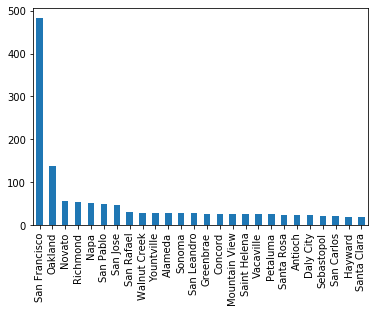

In [427]:
rated_v['Venue City'].value_counts().plot(kind='bar')

In [523]:
# Keep venues with more than 250 reviews
rated_v = rated_v[rated_v['reviews'].astype(float)>250]

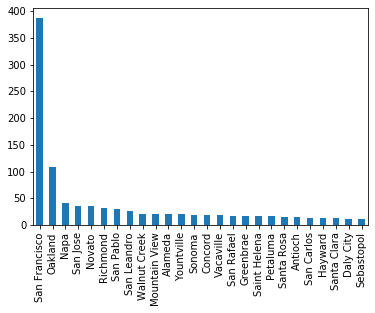

In [430]:
# Check Distribution of venues
rated_v['Venue City'].value_counts().plot(kind='bar')

In [453]:
# make a dictionary of cluster labels with hospital name as key and cluster label as value
cluster_dict = {}
for x in sf_merged.index:
    cluster_dict[sf_merged.iloc[x, 2]] = sf_merged.iloc[x, 7]

In [537]:
# put cluster label column in venue map
rated_v['Cluster'] = rated_v["Hospital"].map(cluster_dict)

In [464]:
len(rated_v['Venue'].unique())

754

Text(0.5, 1.0, 'Number of venues per Cluster Label')

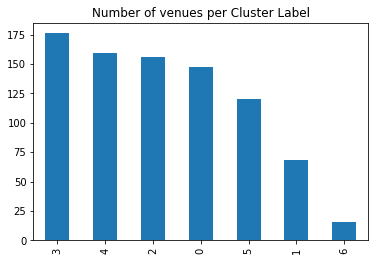

In [508]:
rated_v['Cluster'].value_counts().plot(kind='bar')
plt.title('Number of venues per Cluster Label')

In [469]:
#load a csv of hospital addresses
hospital_address = pd.read_csv('../data/corrected_addresses.csv')

In [526]:
# load marin county hospitals
add = pd.read_csv('../data/marin_hospit.csv')

In [528]:
#merge the two address csvs
hospital_address = pd.concat([hospital_address, add])

In [529]:
#add hospital addresses to dataframe
rated_v = rated_v.merge(hospital_address[['name', 'address']], left_on='Hospital', right_on='name')

In [530]:
#Number of unique food categories
rated_v['Venue Category'].unique().shape

(80,)

In [531]:
# count popular food venues by category
food = rated_v.groupby(['Venue Category'])['Hospital'].count()

Text(0.5, 1.0, 'Top Twenty Venue Categories')

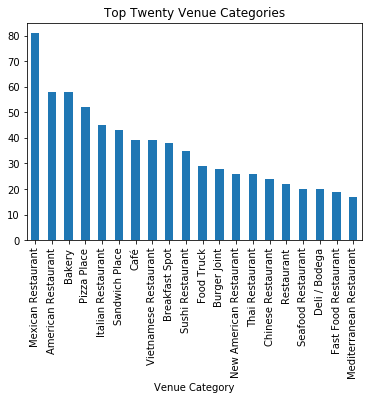

In [532]:
#top 20 venues
food.sort_values(ascending=False)[0:20].plot(kind='bar')
plt.title('Top Twenty Venue Categories')

In [538]:
#create unique icons for folium map
icon_dict = {}
for x in food.index:
    
    if 'restaurant' in x.lower():
        icon_dict[x] = {'icon': 'cutlery'}
    
    elif 'mexican' in x.lower():
        icon_dict[x] = {'icon': 'star'}
       
    elif 'pizza' in x.lower():
         icon_dict[x] = {'icon': 'flag'}
            
    elif 'hot dog' in x.lower():
         icon_dict[x] = {'icon': 'flag'}
            
    elif 'burger' in x.lower():
         icon_dict[x] = {'icon': 'flag'}
            
    elif 'bakery' in x.lower():
         icon_dict[x] = {'icon': 'birthday-cake'}
            
    elif 'truck' in x.lower():
         icon_dict[x] = {'icon': 'truck'}
            
    elif 'breakfast' in x.lower():
         icon_dict[x] = {'icon': 'lemon-o'}
    
    elif 'caf' in x.lower():
         icon_dict[x] = {'icon': 'coffee'}
            
    elif 'vegan' in x.lower():
         icon_dict[x] = {'icon': 'lemon-o'}
            
    elif 'place' or 'deli' in x.lower():
        icon_dict[x] = {'icon': 'circle-o'}
        
    elif 'pub' in x.lower():
        icon_dict[x] = {'icon': 'beer'}
    
    elif 'bbq' in x.lower():
        icon_dict[x] = {'icon': 'circle-o'}
    
    else:
         icon_dict[x] = {'icon': 'dot-circle'}

In [539]:
# create map of San Francisco using latitude and longitude values
map_sf = folium.Map(location=[sf_lat, sf_long], zoom_start=11)

# add markers to map
# hospital markers
for lat, lng, hospital, address in zip(sf_merged['lat'], sf_merged['lng'],\
                              sf_merged['name'], sf_merged['address']):
    if len(address.split()) >3 : 
        new_add = address.split()[:-3]
        new_add[-1] = new_add[-1].replace(',',"")
        new_add = " ".join(new_add)
    else:
        new_add = address
    
    label = '{}\n{}'.format(hospital,new_add)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        location = [lat, lng],
        radius=5,
        popup=label,
        icon=folium.Icon(color="red",icon="ambulance", prefix='fa'),
        parse_html=False).add_to(map_sf)
    
# venue markers
for v_lat, v_long, name, category, rating, reviews, cluster, yelp in zip(rated_v['Venue Latitude'], rated_v['Venue Longitude'], \
                                         rated_v['Venue'], rated_v['Venue Category'], rated_v['ratings'], \
                                        rated_v['reviews'], rated_v['Cluster'], rated_v['yelp_link']):
        label = '{}\nhas {} stars and {}reviews.\n{}'.format(name, rating, reviews, yelp)
        label = folium.Popup(label, parse_html=True)
        color_ = color_dict[cluster]
        icon_ = icon_dict[category]['icon']
        folium.Marker(location = [v_lat, v_long], radius=2, popup=label,
             icon=folium.Icon(color=color_,icon=icon_, prefix='fa'),
              parse_html=False).add_to(map_sf)
    

# choropleth Covid
folium.Choropleth(
    geo_data=df_geo,
    data=bay_area_covid,
    columns=['county', '% of Cases'],
    key_on= 'properties.COUNTY',
    fill_color='BuPu',
    bins=5,
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='Percent of Covid Cases Cumulative to the Bay Area April 28th 2020(%)',
    highlight=True
).add_to(map_sf)

tooltip=folium.GeoJsonTooltip(
    fields=['county','% of Cases'],
    aliases=["County:", "% of Cases to total cases in the Area"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        
        
    """
)

g = folium.GeoJson(
    df_geo,
    tooltip=tooltip,
).add_to(map_sf)
                       
    
map_sf

In [540]:
map_sf.save("venues_hospitals_covid.html")